# Setup

In [ ]:
import os

CEDAR_PATH = "signatures"
CLEAN_DIR = os.path.join(CEDAR_PATH, "full_forg")
IMG_SIZE = (224, 224) 


# Dataset Loader


In [2]:
import random
from augmentations import get_aug


def build_dataset(data_dir, sample_frac=0.2):
    img_files = [os.path.join(data_dir, f) for f in os.listdir(data_dir) if f.endswith(".png")]
    random.shuffle(img_files)
    img_files = img_files[:int(len(img_files)*sample_frac)]
    
    clean, noisy = get_aug(img_files, img_target_size=IMG_SIZE)
    return noisy, clean

noisy, clean = build_dataset(CLEAN_DIR, sample_frac=0.3)
print("Noisy:", noisy.shape, "\nClean:", clean.shape)


Noisy: (396, 224, 224, 1) 
Clean: (396, 224, 224, 1)


In [21]:
from sklearn.model_selection import train_test_split

noisy_train, noisy_val, clean_train, clean_val = train_test_split(noisy, clean, test_size=0.1, random_state=42)


In [4]:
print("noisy_train shape:", noisy_train.shape)
print("noisy_val shape:", noisy_val.shape)
print("\nclean_train shape:", clean_train.shape)
print("clean_val shape:", clean_val.shape)

noisy_train shape: (59, 224, 224, 1)
noisy_val shape: (337, 224, 224, 1)

clean_train shape: (59, 224, 224, 1)
clean_val shape: (337, 224, 224, 1)


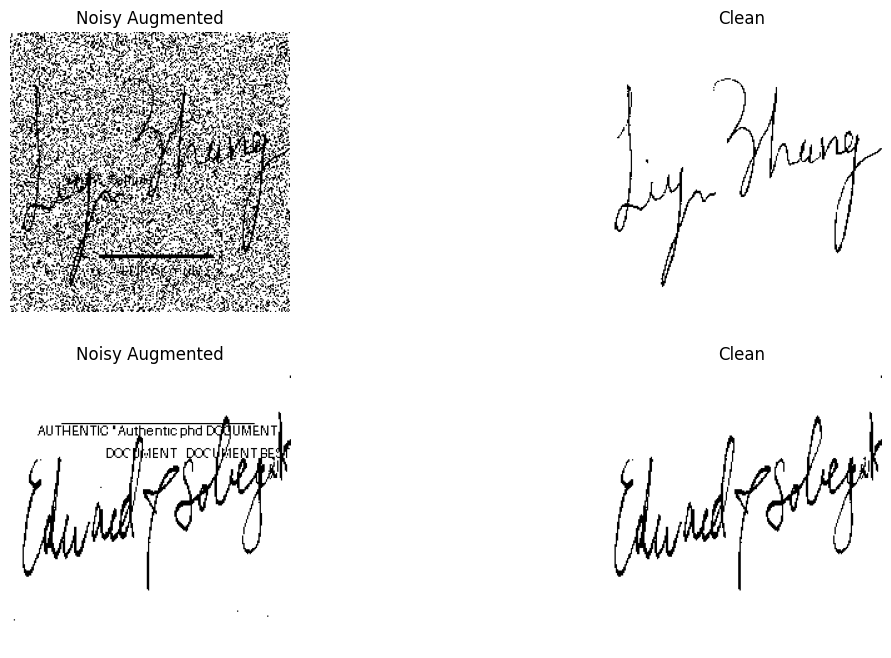

In [24]:
from visualization import show_noisy_clean_pairs

show_noisy_clean_pairs(noisy, clean, num_pairs=2)

# Model Creation

In [36]:
from model import build_light_unet
import tensorflow as tf

model = build_light_unet(input_shape=(224,224,1))

model.load_weights("experiments/checkpoints/unet_weights.weights.h5")


INIT_LR = 1e-3
optimizer = tf.keras.optimizers.Adam(learning_rate=INIT_LR)

model.compile(optimizer=optimizer, loss="binary_crossentropy", metrics=["accuracy"])
# model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
# model.summary()
# model = tf.models.lo

model.name




'light_unet'

In [9]:
from tensorflow.keras.models import load_model # type: ignore
# model = load_model(r'experiments\checkpoints\unet_best.keras')

In [37]:
model.weights[:1][0][0]

<tf.Tensor: shape=(3, 1, 1), dtype=float32, numpy=
array([[[-0.18667819]],

       [[ 0.31021363]],

       [[-0.28116083]]], dtype=float32)>

In [35]:
model.weights[:1][0][0]

<tf.Tensor: shape=(3, 1, 1), dtype=float32, numpy=
array([[[-0.18667819]],

       [[ 0.31021363]],

       [[-0.28116083]]], dtype=float32)>

# Training Setup

In [16]:
from tensorflow.keras.callbacks import ReduceLROnPlateau #type: ignore

lr_scheduler = ReduceLROnPlateau(
    monitor="val_loss", factor=0.5, patience=5, verbose=1, min_lr=1e-6 , max_lr=0.6
)
lr_scheduler


In [29]:
from tensorflow.keras.callbacks import ModelCheckpoint #type: ignore

checkpoint_cb = ModelCheckpoint(
    filepath="experiments/checkpoints/unet_weights.weights.h5",   
    save_best_only=True,
    save_weights_only=True,
    monitor="val_loss",
    mode="min",
    verbose=1
)

checkpoint_cb


In [18]:
from tensorflow.keras.callbacks import EarlyStopping #type: ignore

early_stop = EarlyStopping(
    monitor="val_loss",
    patience=10,
    restore_best_weights=True,
    verbose=1
)

early_stop

In [39]:
EPOCHS = 10
callbacks = [
    lr_scheduler,
    checkpoint_cb,
    early_stop
]

history = model.fit(
    noisy_train, clean_train,
    validation_data=(noisy_val, clean_val),
    epochs=EPOCHS, batch_size=1,
    callbacks=callbacks
)

# model.save(f"experiments\\results\\model{1}.keras")

Epoch 1/10
356/356 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - accuracy: 0.9938 - loss: 0.0180
Epoch 1: val_loss did not improve from 0.02819
356/356 ━━━━━━━━━━━━━━━━━━━━ 40s 101ms/step - accuracy: 0.9938 - loss: 0.0179 - val_accuracy: 0.9811 - val_loss: 0.0430 - learning_rate: 0.0010
Epoch 2/10
356/356 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - accuracy: 0.9942 - loss: 0.0166
Epoch 2: val_loss did not improve from 0.02819
356/356 ━━━━━━━━━━━━━━━━━━━━ 35s 97ms/step - accuracy: 0.9940 - loss: 0.0173 - val_accuracy: 0.9785 - val_loss: 0.0505 - learning_rate: 0.0010
Epoch 3/10
356/356 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - accuracy: 0.9934 - loss: 0.0182
Epoch 3: val_loss did not improve from 0.02819
356/356 ━━━━━━━━━━━━━━━━━━━━ 35s 99ms/step - accuracy: 0.9941 - loss: 0.0166 - val_accuracy: 0.9816 - val_loss: 0.0432 - learning_rate: 0.0010
Epoch 4/10
356/356 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - accuracy: 0.9944 - loss: 0.0157
Epoch 4: val_loss did not improve from 0.02819
356/356 ━━━━━━━━━━━━━━━━━━━━ 35s 9

# Prediction / Model performance 

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


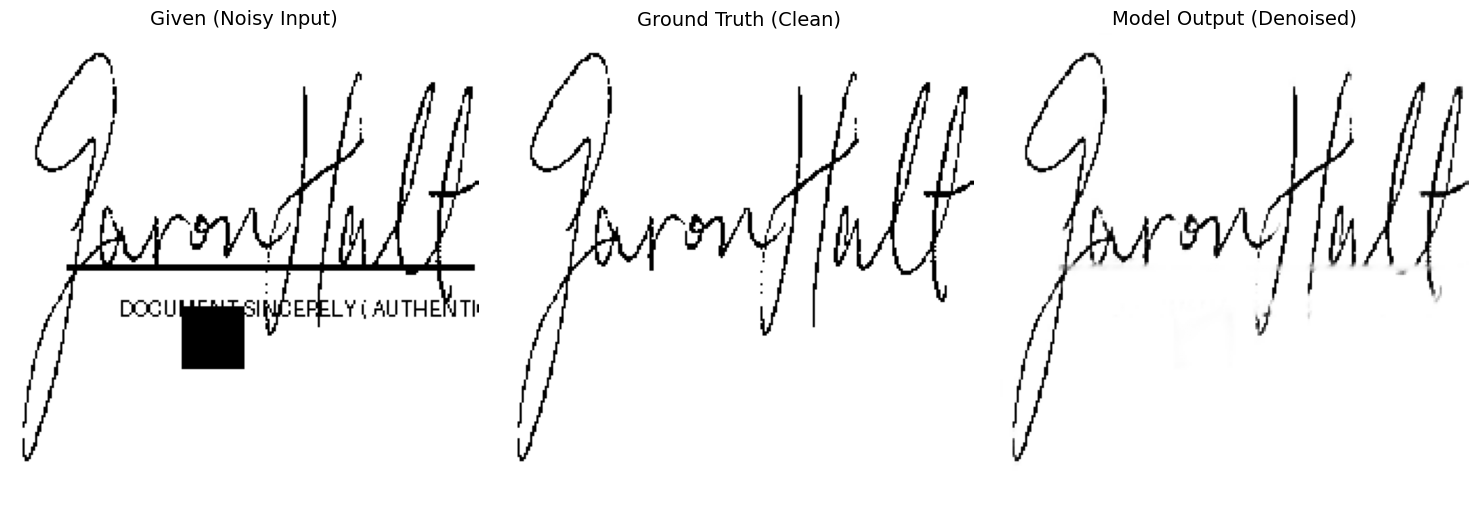

In [44]:
import tensorflow as tf
from visualization import visualize_prediction

# Path to your best checkpoint
checkpoint_path = "experiments/checkpoints/unet_best.keras"

# Load the trained model
model = tf.keras.models.load_model(checkpoint_path, compile=True)

noisy_test, clean_test = noisy[:100], clean[:100]  

# Visualize first sample
visualize_prediction(noisy_test, clean_test, idx=random.randint(0,len(noisy_test)) , mdl = model )
